In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import optuna

Step 1: Load the dataset
Data loaded successfully
Step 2: Handle missing values
Missing values handled
Step 3: Convert statezip to numeric
statezip converted to numeric
Step 4: Drop non-numeric columns for correlation matrix
Non-numeric columns dropped for correlation matrix
Step 5: Display the correlation matrix


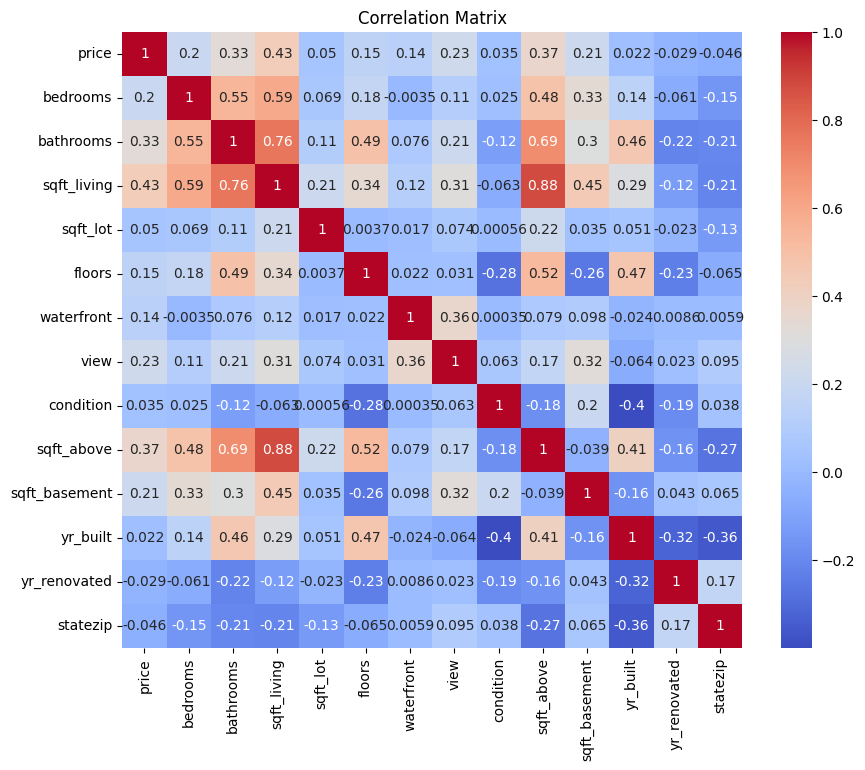

Correlation matrix displayed
Step 6: Remove outliers based on the IQR method
Outliers removed


In [2]:
print("Step 1: Load the dataset")
# Load the dataset
data_path = "data.csv"
df = pd.read_csv(data_path)
print("Data loaded successfully")

print("Step 2: Handle missing values")
# Handle missing values
df.dropna(inplace=True)
print("Missing values handled")

print("Step 3: Convert statezip to numeric")
# Convert statezip to numeric
df["statezip"] = df["statezip"].apply(lambda x: int(x.split(" ")[1]))
print("statezip converted to numeric")

print("Step 4: Drop non-numeric columns for correlation matrix")
# Drop non-numeric columns for correlation matrix
df_numeric = df.select_dtypes(include=[np.number])
print("Non-numeric columns dropped for correlation matrix")

print("Step 5: Display the correlation matrix")
# Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()
print("Correlation matrix displayed")

print("Step 6: Remove outliers based on the IQR method")
# Remove outliers based on the IQR method (only on numeric columns)
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
df_numeric = df_numeric[
    ~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
]
print("Outliers removed")

In [3]:
print("Step 7: Re-integrate non-numeric columns after outlier removal")
# Re-integrate non-numeric columns after outlier removal
df = df.loc[df_numeric.index]
print("Non-numeric columns re-integrated after outlier removal")

print("Step 8: Feature Engineering")
# Feature Engineering: Add polynomial features and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[["sqft_living", "sqft_above", "sqft_basement"]])
poly_feature_names = poly.get_feature_names_out(
    ["sqft_living", "sqft_above", "sqft_basement"]
)
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
df = pd.concat([df, df_poly], axis=1)
print("Advanced feature engineering applied")

print("Step 9: Define features and target")
# Define features and target
features = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "floors",
    "statezip",
    "waterfront",
    "view",
    "sqft_above",
    "sqft_basement",
    "yr_renovated",
] + list(poly_feature_names)
X = df[features]
y = df["price"]
print("Features and target defined")

print("Step 10: Split the data into training and test sets")
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Data split into training and test sets")

print("Step 11: Feature scaling")
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled")

Step 7: Re-integrate non-numeric columns after outlier removal
Non-numeric columns re-integrated after outlier removal
Step 8: Feature Engineering
Advanced feature engineering applied
Step 9: Define features and target
Features and target defined
Step 10: Split the data into training and test sets
Data split into training and test sets
Step 11: Feature scaling
Features scaled


In [4]:
print("Step 12: Hyperparameter tuning for XGBoost using Optuna")


# Define the objective function for Optuna
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    model = xgb.XGBRegressor(**param, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring="r2")
    return np.mean(cv_scores)


# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=1800)  # Reduced number of trials
print("Optuna optimization completed")

# Best parameters from Optuna
print(f"Best parameters: {study.best_params}")
best_params = study.best_params

# Train the final model with the best parameters
model = xgb.XGBRegressor(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("Final model trained and predictions made")

[I 2024-05-22 16:51:16,310] A new study created in memory with name: no-name-e70d1c58-8e4e-42ac-9248-802e2164b457


Step 12: Hyperparameter tuning for XGBoost using Optuna


[I 2024-05-22 16:51:19,672] Trial 0 finished with value: 0.7354151790595524 and parameters: {'max_depth': 3, 'learning_rate': 0.09905790888587654, 'n_estimators': 709, 'subsample': 0.8568387069528264, 'colsample_bytree': 0.9806987558465816, 'min_child_weight': 5}. Best is trial 0 with value: 0.7354151790595524.
[I 2024-05-22 16:51:22,894] Trial 1 finished with value: 0.7072822464409617 and parameters: {'max_depth': 6, 'learning_rate': 0.10722023232223032, 'n_estimators': 335, 'subsample': 0.9145407875491156, 'colsample_bytree': 0.9480252634995427, 'min_child_weight': 5}. Best is trial 0 with value: 0.7354151790595524.
[I 2024-05-22 16:51:25,580] Trial 2 finished with value: 0.7101057613734337 and parameters: {'max_depth': 4, 'learning_rate': 0.14545999351246894, 'n_estimators': 500, 'subsample': 0.7953082539593924, 'colsample_bytree': 0.6535319325170554, 'min_child_weight': 4}. Best is trial 0 with value: 0.7354151790595524.
[I 2024-05-22 16:51:26,372] Trial 3 finished with value: 0.69

Optuna optimization completed
Best parameters: {'max_depth': 3, 'learning_rate': 0.0453541331334368, 'n_estimators': 869, 'subsample': 0.7833967334827489, 'colsample_bytree': 0.7576266832188607, 'min_child_weight': 9}
Final model trained and predictions made


In [5]:
print("Step 13: Feature importances")
# Extract the actual feature names used by the model
actual_feature_names = X.columns[model.feature_importances_ != 0]
feature_importances = model.feature_importances_[model.feature_importances_ != 0]

print(f"Length of actual features: {len(actual_feature_names)}")
print(f"Length of feature importances: {len(feature_importances)}")

# Create DataFrame for feature importances
features_importance_df = pd.DataFrame(
    {"Feature": actual_feature_names, "Importance": feature_importances}
)

features_importance_df = features_importance_df.sort_values(
    by="Importance", ascending=False
)

print("\nFeature Importances:")
print(features_importance_df)

print("Step 14: Calculate evaluation metrics")
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r_squared:.2f}")

Step 13: Feature importances
Length of actual features: 22
Length of feature importances: 22

Feature Importances:
                      Feature  Importance
3                 sqft_living    0.235373
2                 sqft_living    0.157420
5                    statezip    0.097006
14                 sqft_above    0.081381
18     sqft_living sqft_above    0.044037
15              sqft_basement    0.040538
13                 sqft_above    0.033923
8               sqft_basement    0.028985
0                    bedrooms    0.027959
4                      floors    0.027455
9               sqft_basement    0.027049
16              sqft_basement    0.024330
6                  sqft_above    0.021262
1                   bathrooms    0.020689
19  sqft_living sqft_basement    0.020378
11                sqft_living    0.019603
20               sqft_above^2    0.018640
21   sqft_above sqft_basement    0.016274
7                  sqft_above    0.015643
17              sqft_living^2    0.015257
10 

Step 15: Visualize results


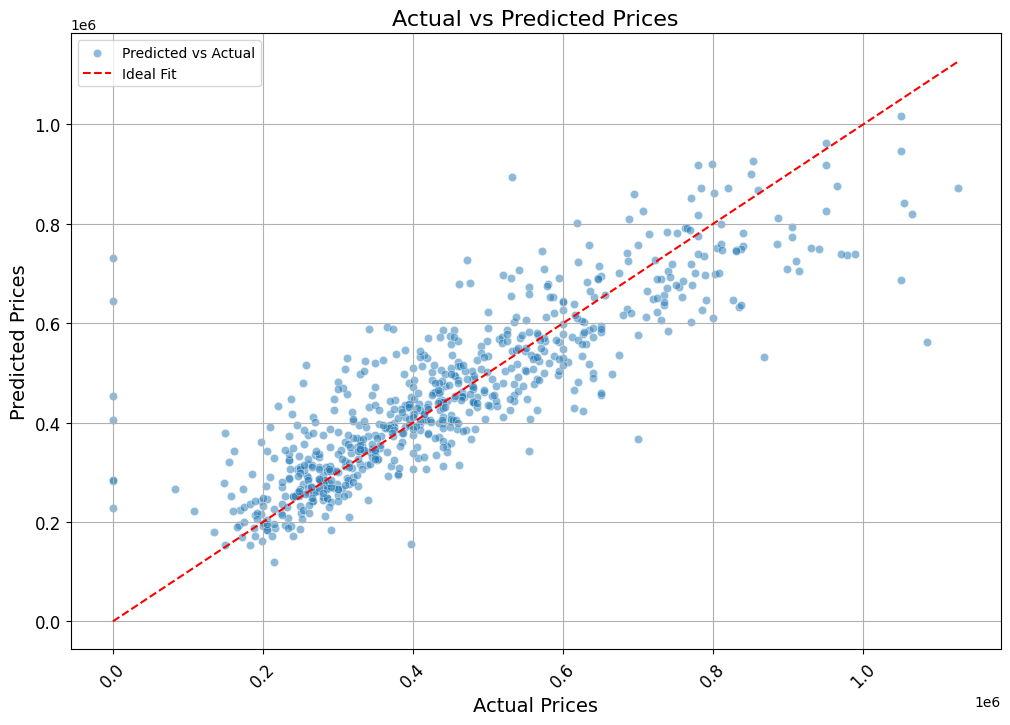

Results visualized
Step 16: Cross-Validation
Cross-Validation Scores: [0.7151482  0.76408791 0.73078797 0.74283324 0.74646926]
Mean CV Score: 0.74


In [6]:
print("Step 15: Visualize results")
# Visualize results
plt.figure(figsize=(12, 8))
plt.scatter(
    y_test,
    y_pred,
    alpha=0.5,
    edgecolors="w",
    linewidth=0.5,
    label="Predicted vs Actual",
)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    label="Ideal Fit",
)
plt.xlabel("Actual Prices", fontsize=14)
plt.ylabel("Predicted Prices", fontsize=14)
plt.title("Actual vs Predicted Prices", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
print("Results visualized")

print("Step 16: Cross-Validation")
# Cross-Validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")
